In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
import scipy.interpolate as interpolate
import scipy.stats as stats

In [2]:
plt.rc("figure", dpi=150)
np.random.seed(123)

<Axes: xlabel='temperature', ylabel='rented'>

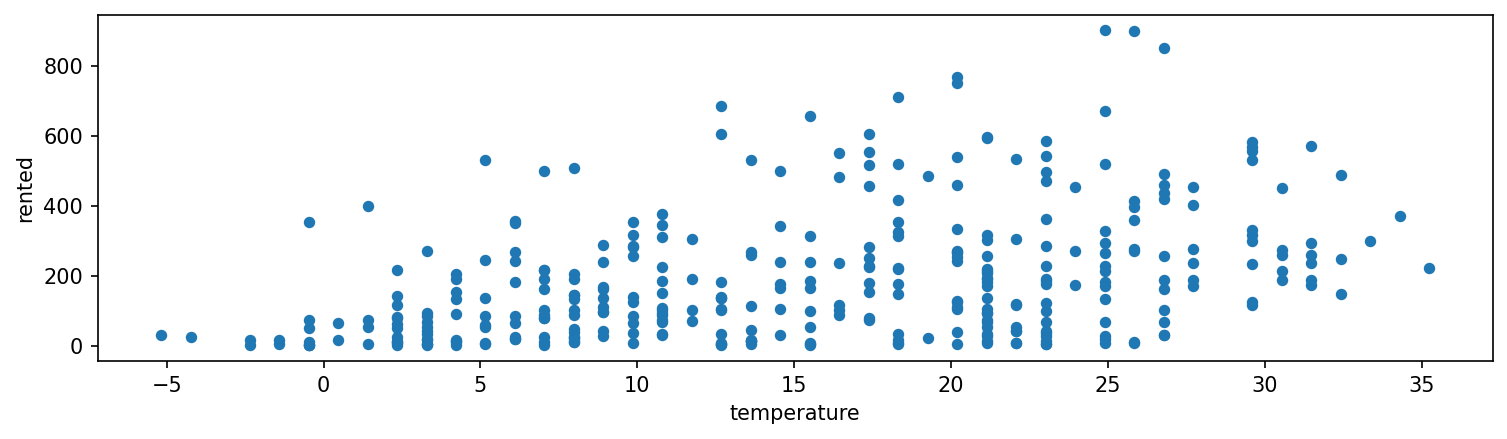

In [3]:
bikes = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [4]:
coords = {"data": np.arange(len(bikes))}
with pm.Model(coords=coords) as model_lb:
    β0 = pm.Normal("β0", mu=0, sigma=100)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", β0 + β1 * bikes.temperature, dims="data")
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented, dims="data")
    

In [5]:
idata_lb = pm.sample(random_seed=123, model=model_lb)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


In [6]:
idata_lb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'β0'}>, <Axes: title={'center': 'β1'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

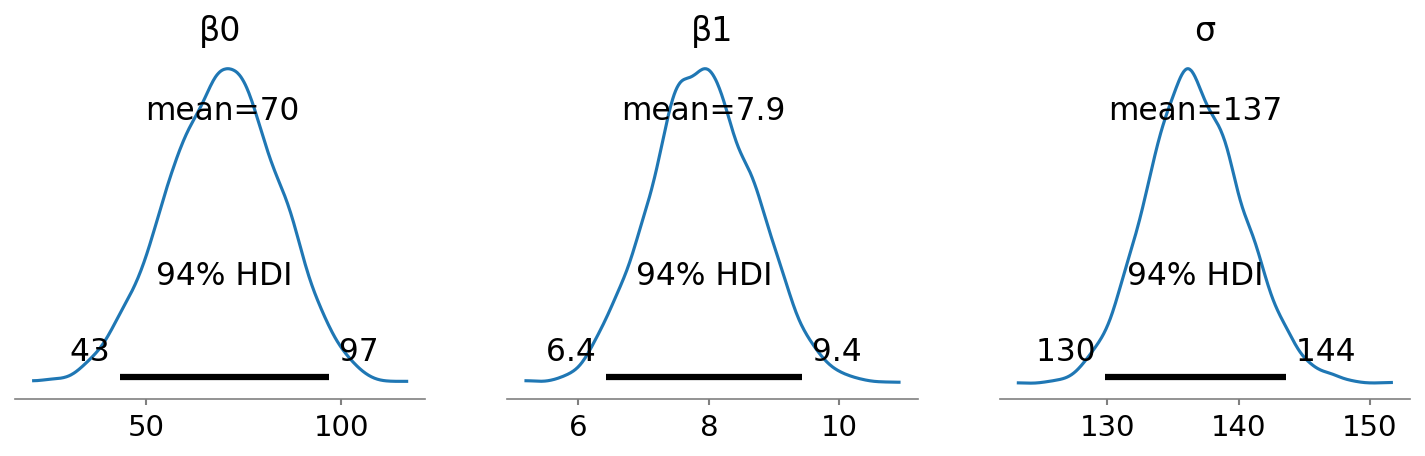

In [7]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

<Axes: xlabel='β0', ylabel='β1'>

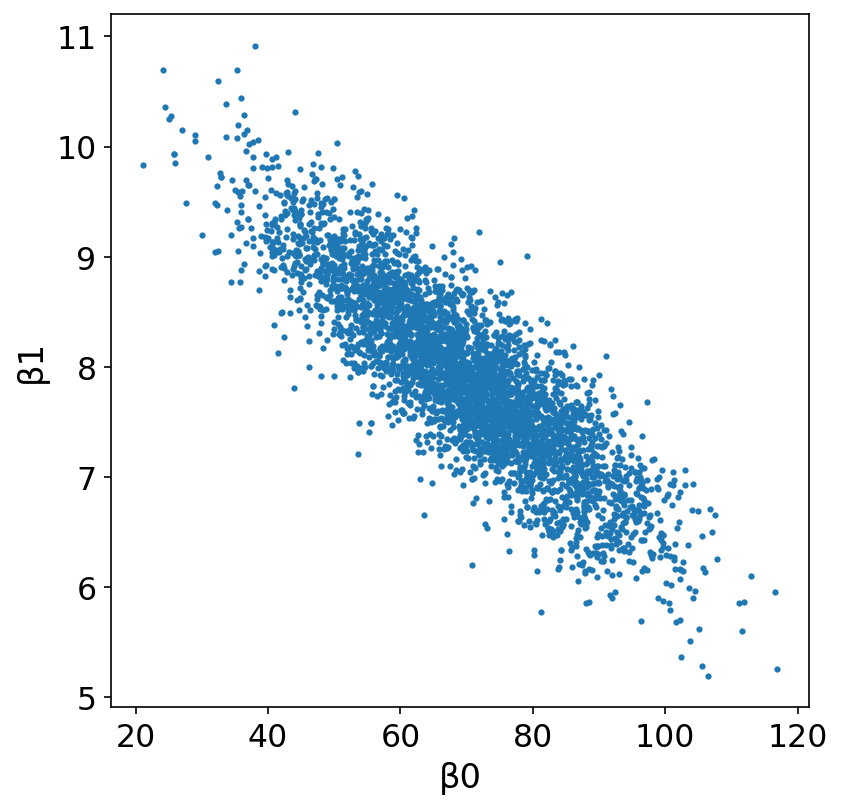

In [8]:
az.plot_pair(idata_lb, var_names=["β0", "β1"], kind="scatter", figsize=(6, 6))

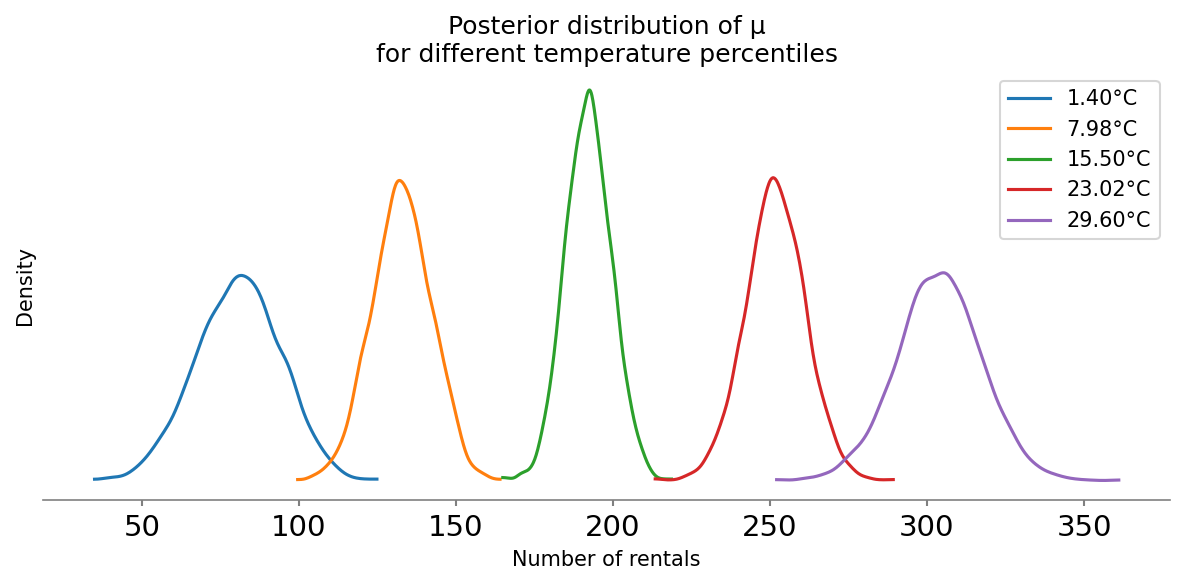

In [9]:
# Define percentiles to calculate
percentiles = [5, 25, 50, 75, 95]

# Initialize list to store indexes
percentile_idxs = []

# Create figure with subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharey=True)

# Calculate percentile indices
for i,p in enumerate(percentiles):
    # Calculate the percentile value
    p_value = np.percentile(bikes.temperature, p)
    
    # Find index where temperature is closest to this value
    idx = np.abs(bikes.temperature - p_value).argmin()
    
    # Store this index
    percentile_idxs.append(idx)
    mu_posterior = idata_lb.posterior["μ"].sel(data=idx)

    temp_value = bikes.temperature.iloc[idx]

    # Plot the posterior distribution
    az.plot_posterior(mu_posterior, ax=axes, point_estimate=None, 
        hdi_prob="hide", label=f"{temp_value:.2f}°C",
        color=f"C{i}")

    axes.set_xlabel('Number of rentals')
    axes.set_ylabel('Density')
    axes.set_title(f"Posterior distribution of μ\nfor different temperature percentiles")


plt.tight_layout()


NameError: name 'ax' is not defined

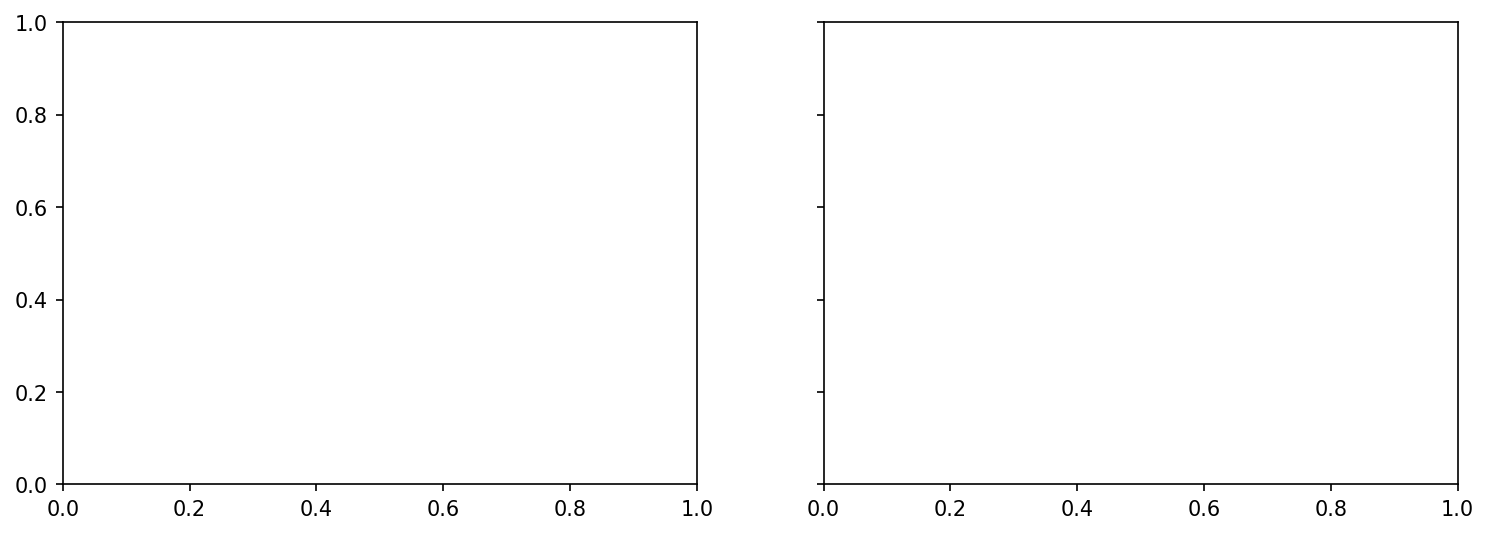

In [10]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)
mean_line = posterior["β0"].mean() + posterior["β1"].mean() * x_plot
lines = posterior["β0"] + posterior["β1"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C3", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
ax.plot(x_plot, mean_line, c="C0", label="mean line")
ax.set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C3",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()

In [ ]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

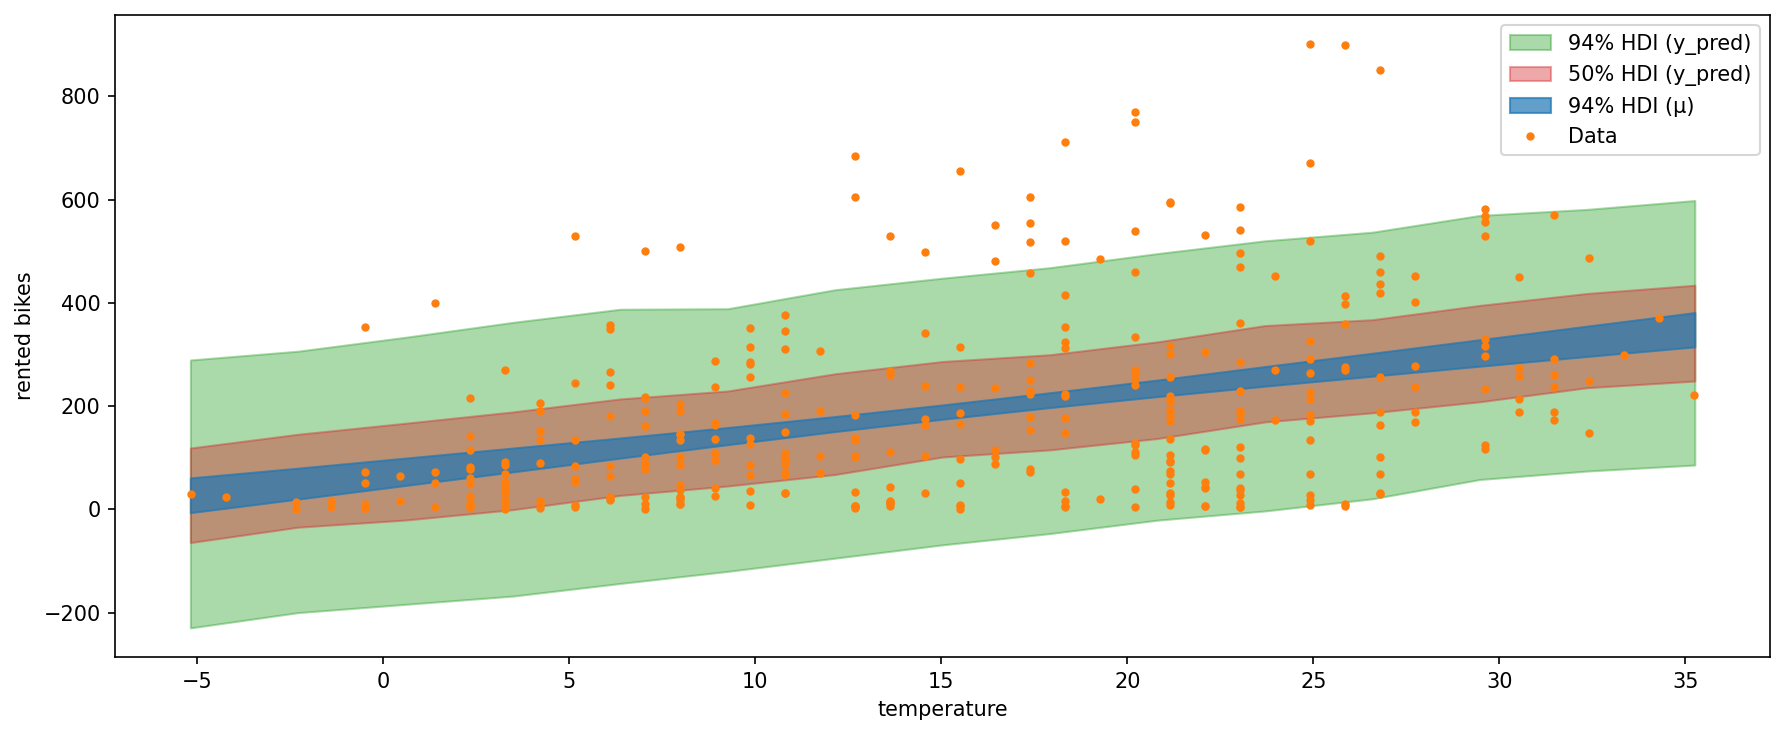

In [ ]:
# Setup
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

HDIs_pp = [0.94, 0.5]  # Multiple HDIs for posterior predictive
HDI_mu = 0.94          # Single HDI for posterior μ

# --- Posterior Predictive HDIs ---
pp_percentiles = []
for hdi in HDIs_pp:
    p_low = (1 - hdi) / 2
    p_high = 1 - p_low
    pp_percentiles.extend([p_low, p_high])

y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(pp_percentiles, dim=["chain", "draw"])

# Interpolated HDI bounds for y_pred
y_hat_bounds = {}
for i, hdi in enumerate(HDIs_pp):
    lb = y_pred_q[2 * i]
    ub = y_pred_q[2 * i + 1]
    y_hat_bounds[hdi] = (
        interpolate.PchipInterpolator(temperatures[idx], lb[idx])(x),
        interpolate.PchipInterpolator(temperatures[idx], ub[idx])(x)
    )

# --- Posterior μ HDI ---
p_low_mu = (1 - HDI_mu) / 2
p_high_mu = 1 - p_low_mu
mu_q = idata_lb.posterior["μ"].quantile([p_low_mu, p_high_mu], dim=["chain", "draw"])

mu_bounds = (
    interpolate.PchipInterpolator(temperatures[idx], mu_q[0][idx])(x),
    interpolate.PchipInterpolator(temperatures[idx], mu_q[1][idx])(x)
)

# --- Plot ---
_, ax = plt.subplots(figsize=(12, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Fill posterior predictive HDIs
for i, hdi in enumerate(HDIs_pp):
    lb, ub = y_hat_bounds[hdi]
    ax.fill_between(x, lb, ub, color=colors[i % len(colors)+2], alpha=0.4, label=f"{int(hdi*100)}% HDI (y_pred)", zorder=i)

# Fill μ HDI
mu_color = 'C0'
ax.fill_between(x, *mu_bounds, color=mu_color, alpha=0.7, label=f"{int(HDI_mu*100)}% HDI (μ)", zorder=len(HDIs_pp))

# Data points
ax.plot(bikes.temperature, bikes.rented, "C1.", label="Data", zorder=len(HDIs_pp)+1)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")
ax.legend()
plt.tight_layout()
plt.show()

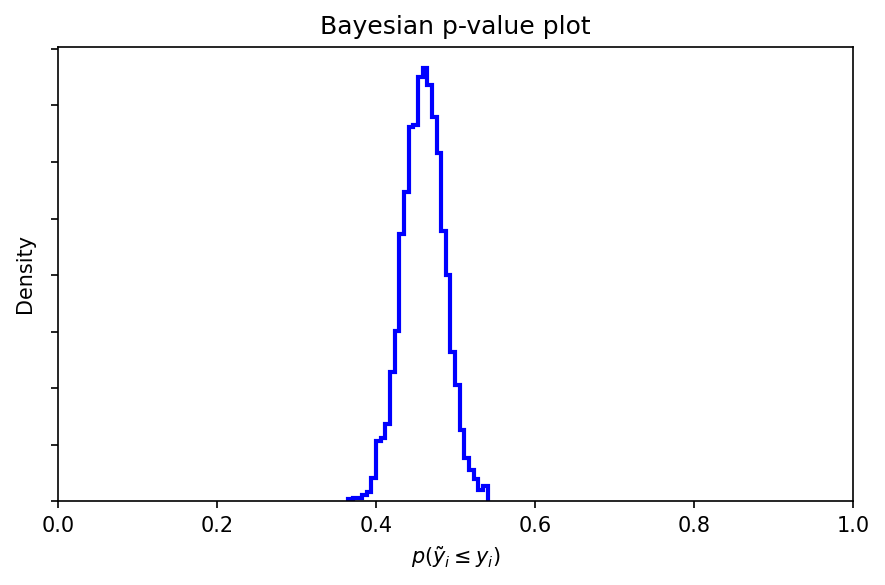

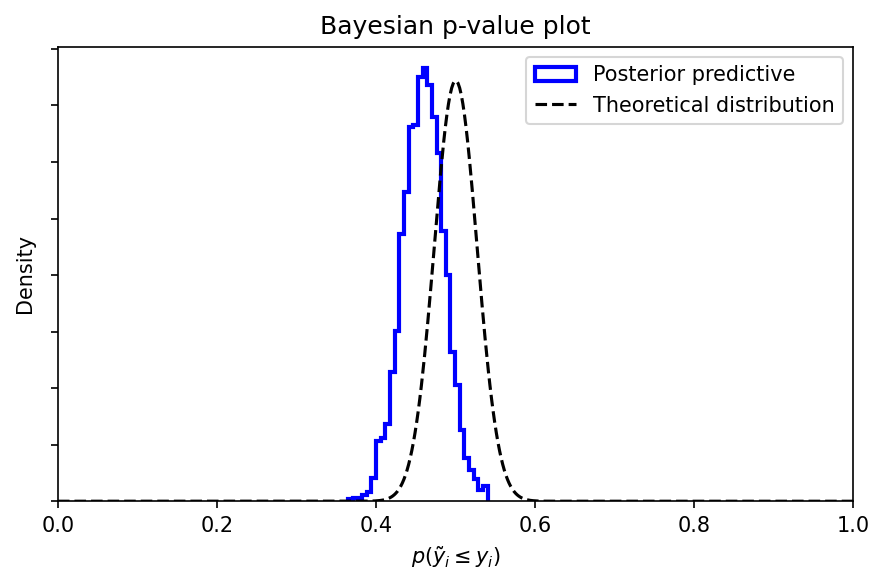

In [ ]:
var_name = 'y_pred'
obs_vals = idata_lb.observed_data[var_name].values.flatten()
pp_vals = idata_lb.posterior_predictive[var_name].stack(sample=("chain", "draw")).values.T

tstat_pit = np.mean(pp_vals <= obs_vals, axis=1)

for plot_reference_distribution in [False, True]:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(tstat_pit, bins=30, density=True, histtype='step', color='blue', linewidth=2, label='Posterior predictive')

    n_obs = len(obs_vals)
    x = np.linspace(0, 1, 500)
    if plot_reference_distribution:
        ax.plot(x, stats.beta.pdf(x, n_obs / 2, n_obs / 2), linestyle='--', color='black', label='Theoretical distribution')

    ax.set_title("Bayesian p-value plot")
    ax.set_xlabel(r"$p(\tilde{y}_{i} \leq y_i)$")
    ax.set_ylabel("Density")
    ax.set_xlim([0,1])
    ax.set_yticklabels([])
    if plot_reference_distribution:
        ax.legend()
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Posterior predictive plot')

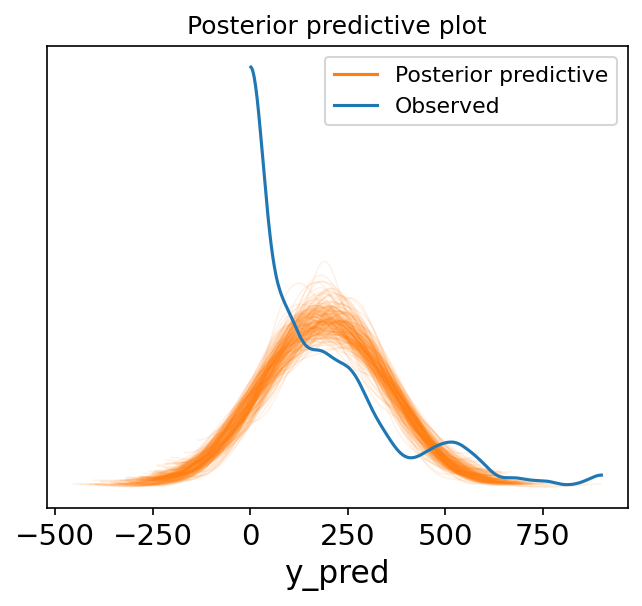

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 4))
az.plot_ppc(
    idata_lb,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax,
    mean=False,
)
ax.set_title("Posterior predictive plot")


In [ ]:
idata_lb.extend(pm.sample_prior_predictive(model=model_lb, random_seed=123), join="right")

Sampling: [y_pred, β0, β1, σ]


Text(0.5, 1.0, 'Prior predictive plot')

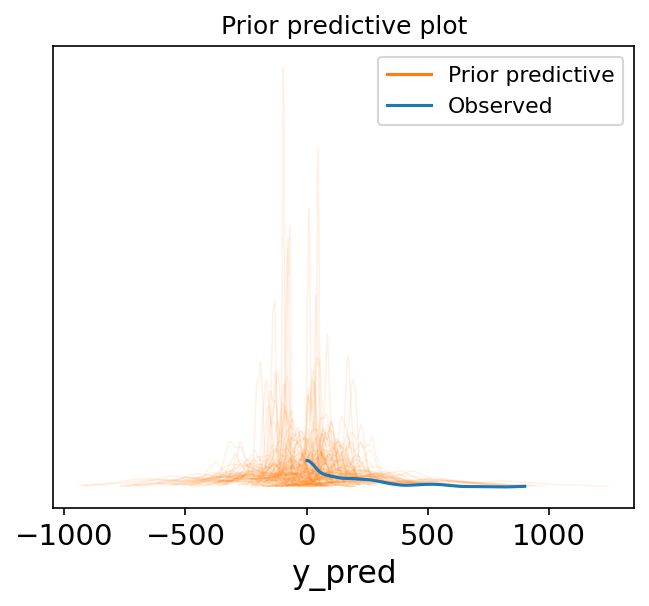

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 4))
az.plot_ppc(
    idata_lb,
    num_pp_samples=200,
    alpha=0.1,
    observed=True,
    group="prior",
    colors=["C1", "C0", "C0"],
    ax=ax,
    mean=False,
)
ax.set_title("Prior predictive plot")

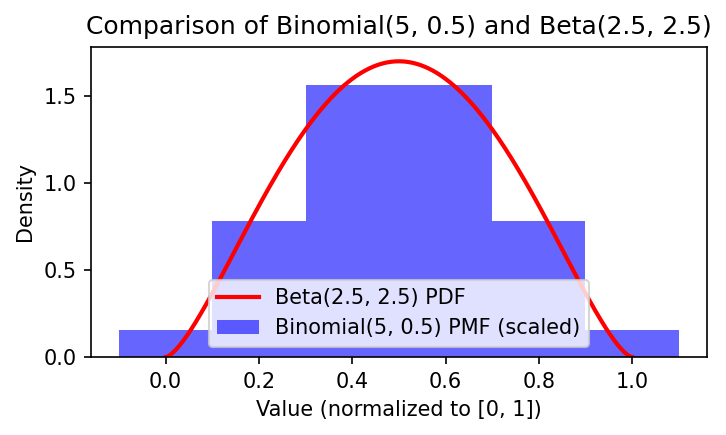

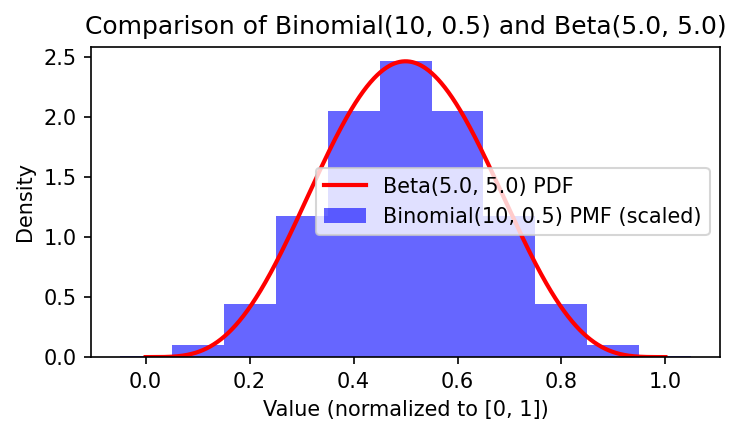

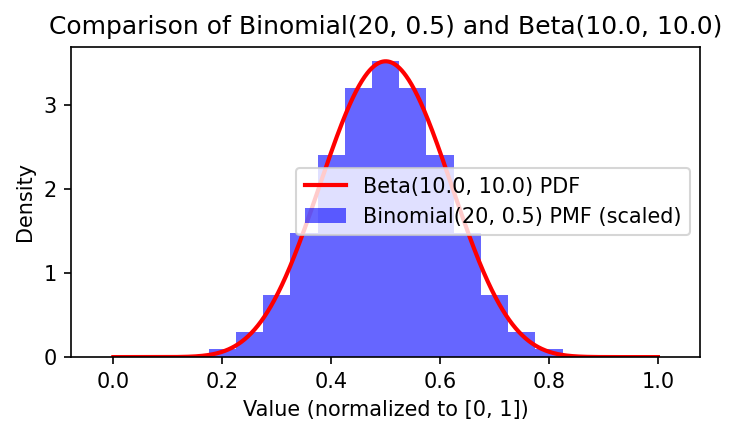

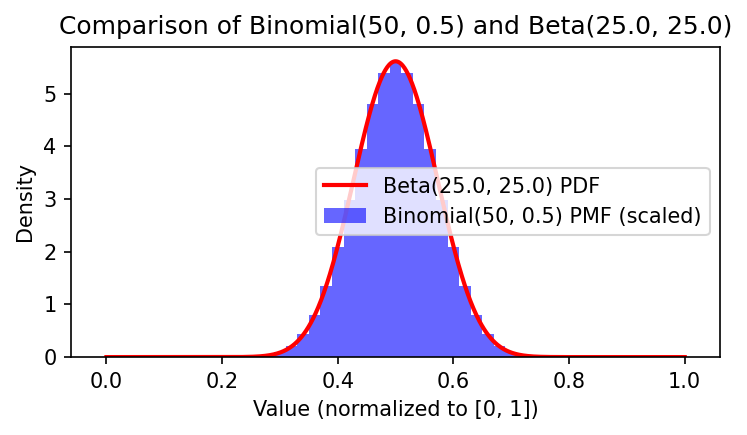

In [ ]:
# Values of n to use
n_values = [5, 10, 20, 50]

for n in n_values:
    fig, ax = plt.subplots(figsize=(5, 3))
    
    # For Binomial(n, 0.5)
    x_binom = np.arange(0, n+1)
    pmf_binom = stats.binom.pmf(x_binom, n, 0.5)
    x_binom_scaled = x_binom / n
    
    # For Beta(n/2, n/2)
    x_beta = np.linspace(0, 1, 1000)
    pdf_beta = stats.beta.pdf(x_beta, n/2, n/2)
    
    # Plot Binomial PMF as bars, scaling appropriately
    ax.bar(x_binom_scaled, pmf_binom * n, width=1/n, alpha=0.6, color='blue', 
           label=f'Binomial({n}, 0.5) PMF (scaled)')
    
    # Plot Beta PDF as a curve
    ax.plot(x_beta, pdf_beta, 'r-', linewidth=2, 
           label=f'Beta({n/2}, {n/2}) PDF')
    
    ax.set_xlabel('Value (normalized to [0, 1])')
    ax.set_ylabel('Density')
    ax.set_title(f'Comparison of Binomial({n}, 0.5) and Beta({n/2}, {n/2})')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

<Axes: title={'center': 'y_pred'}>

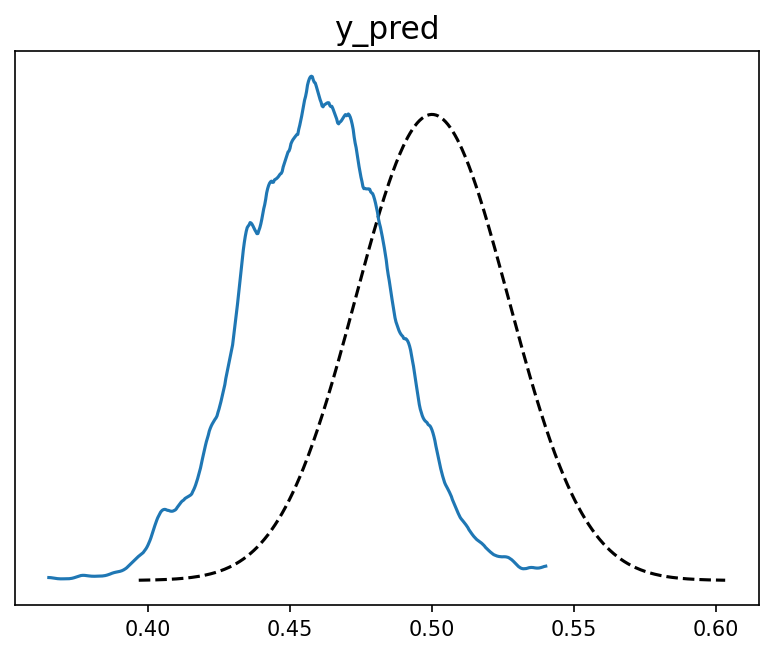

In [ ]:
az.plot_bpv(idata_lb, kind="p_value")

Text(0.5, 0, 'mean($\\tilde{y}_{i}$)')

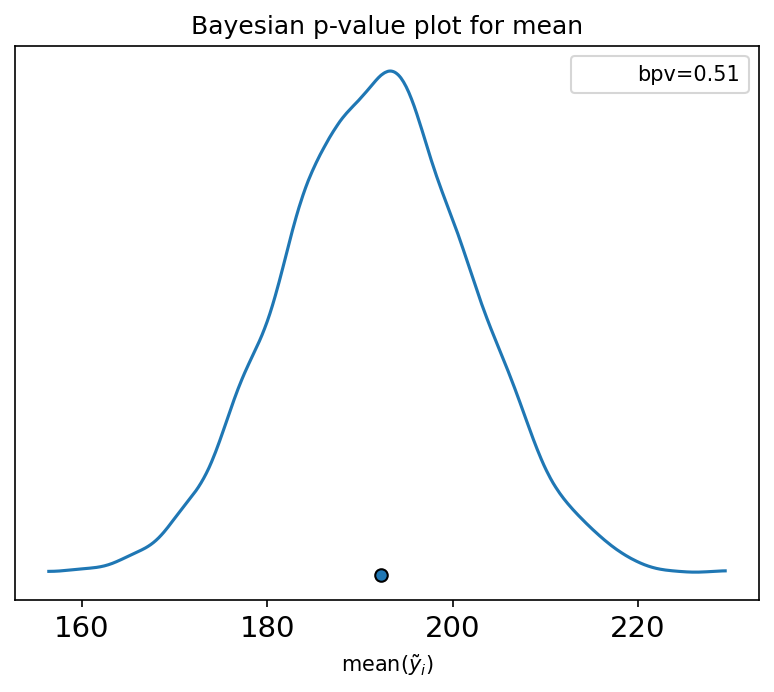

In [ ]:
ax = az.plot_bpv(idata_lb, kind="t_stat", t_stat="mean")
ax.set_title("Bayesian p-value plot for mean")
ax.set_xlabel(r"mean($\tilde{y}_{i}$)")

Text(0.5, 0, 'std($\\tilde{y}_{i}$)')

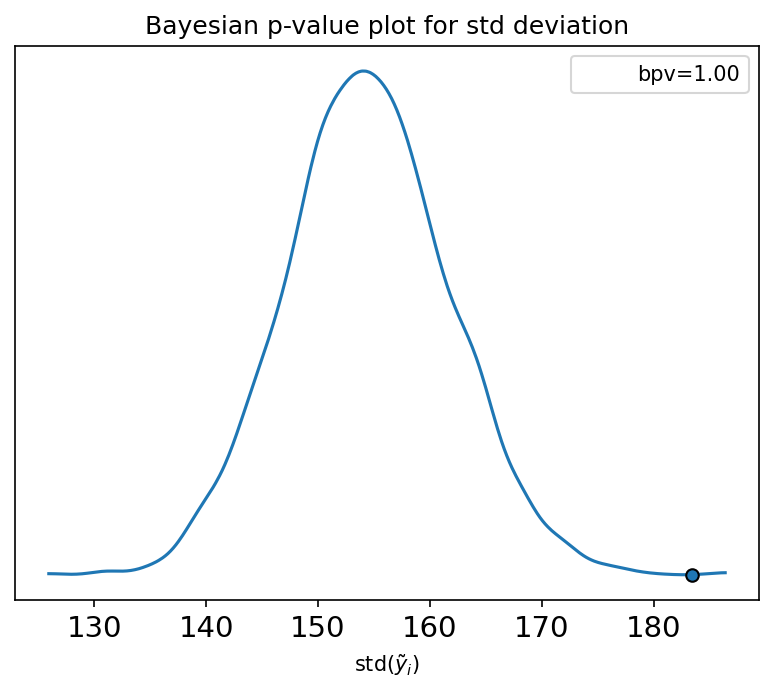

In [ ]:
ax = az.plot_bpv(idata_lb, kind="t_stat", t_stat="std")
ax.set_title("Bayesian p-value plot for std deviation")
ax.set_xlabel(r"std($\tilde{y}_{i}$)")

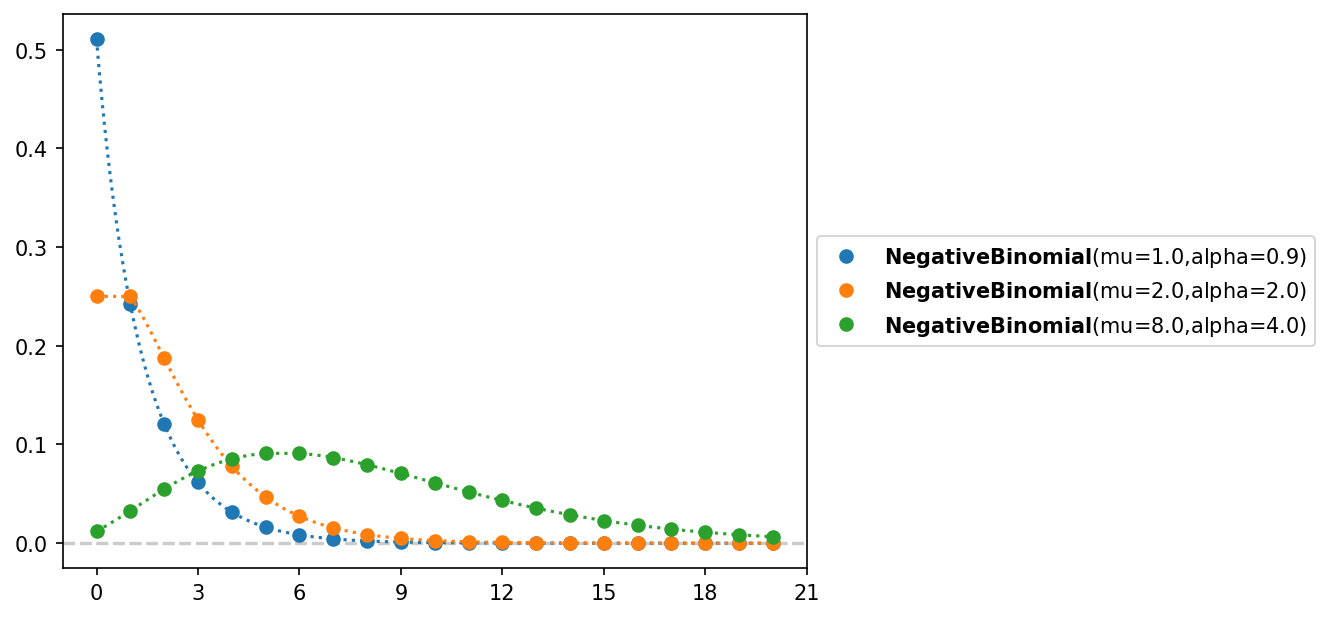

In [ ]:
mus = [1, 2, 8]
alphas = [0.9, 2, 4]
for mu, alpha in zip(mus, alphas):
    pz.NegativeBinomial(mu, alpha).plot_pdf(support=(0, 20))

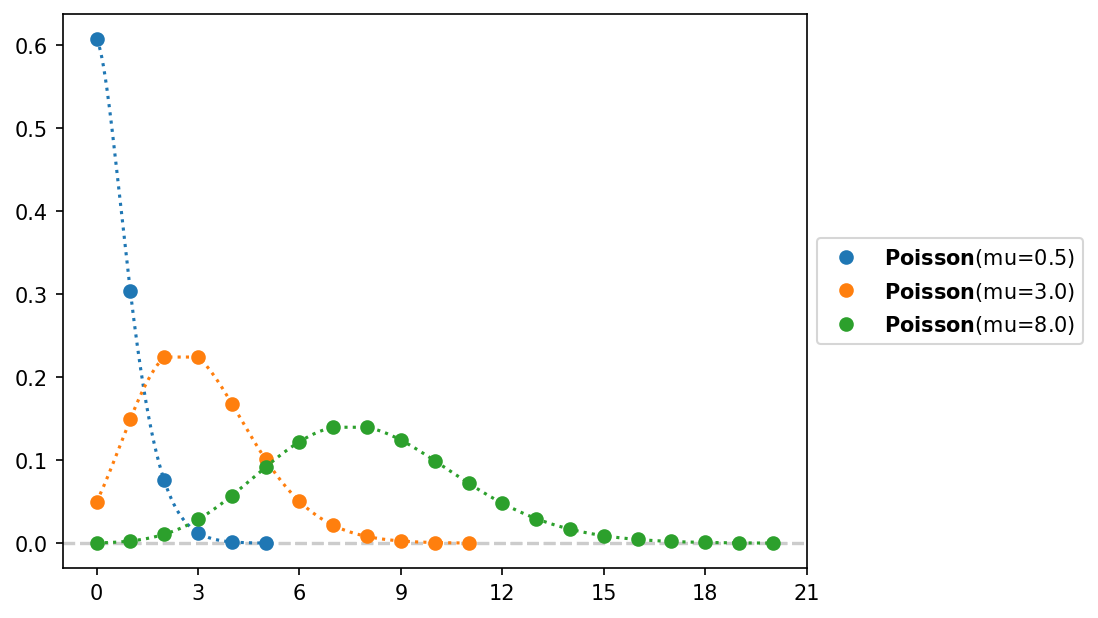

In [ ]:
for mu in [0.5, 3, 8]:
    pz.Poisson(mu).plot_pdf();

In [ ]:
mu_0 = 0
sigma_0 = 1
mu_1 = 0
sigma_1 = 10
sigma_alpha = 10

with pm.Model() as model_neg:
    beta0 = pm.Normal("beta0", mu=mu_0, sigma=sigma_0)
    beta1 = pm.Normal("beta1", mu=mu_1, sigma=sigma_1)
    alpha = pm.HalfNormal("alpha", sigma=sigma_alpha)
    mu = pm.Deterministic("mu", pm.math.exp(beta0 + beta1 * bikes.temperature))
    y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=alpha, observed=bikes.rented)

In [ ]:
idata_neg = pm.sample(random_seed=123, model=model_neg)
idata_neg.extend(pm.sample_posterior_predictive(idata_neg, random_seed=123, model=model_neg))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [y_pred]


Output()

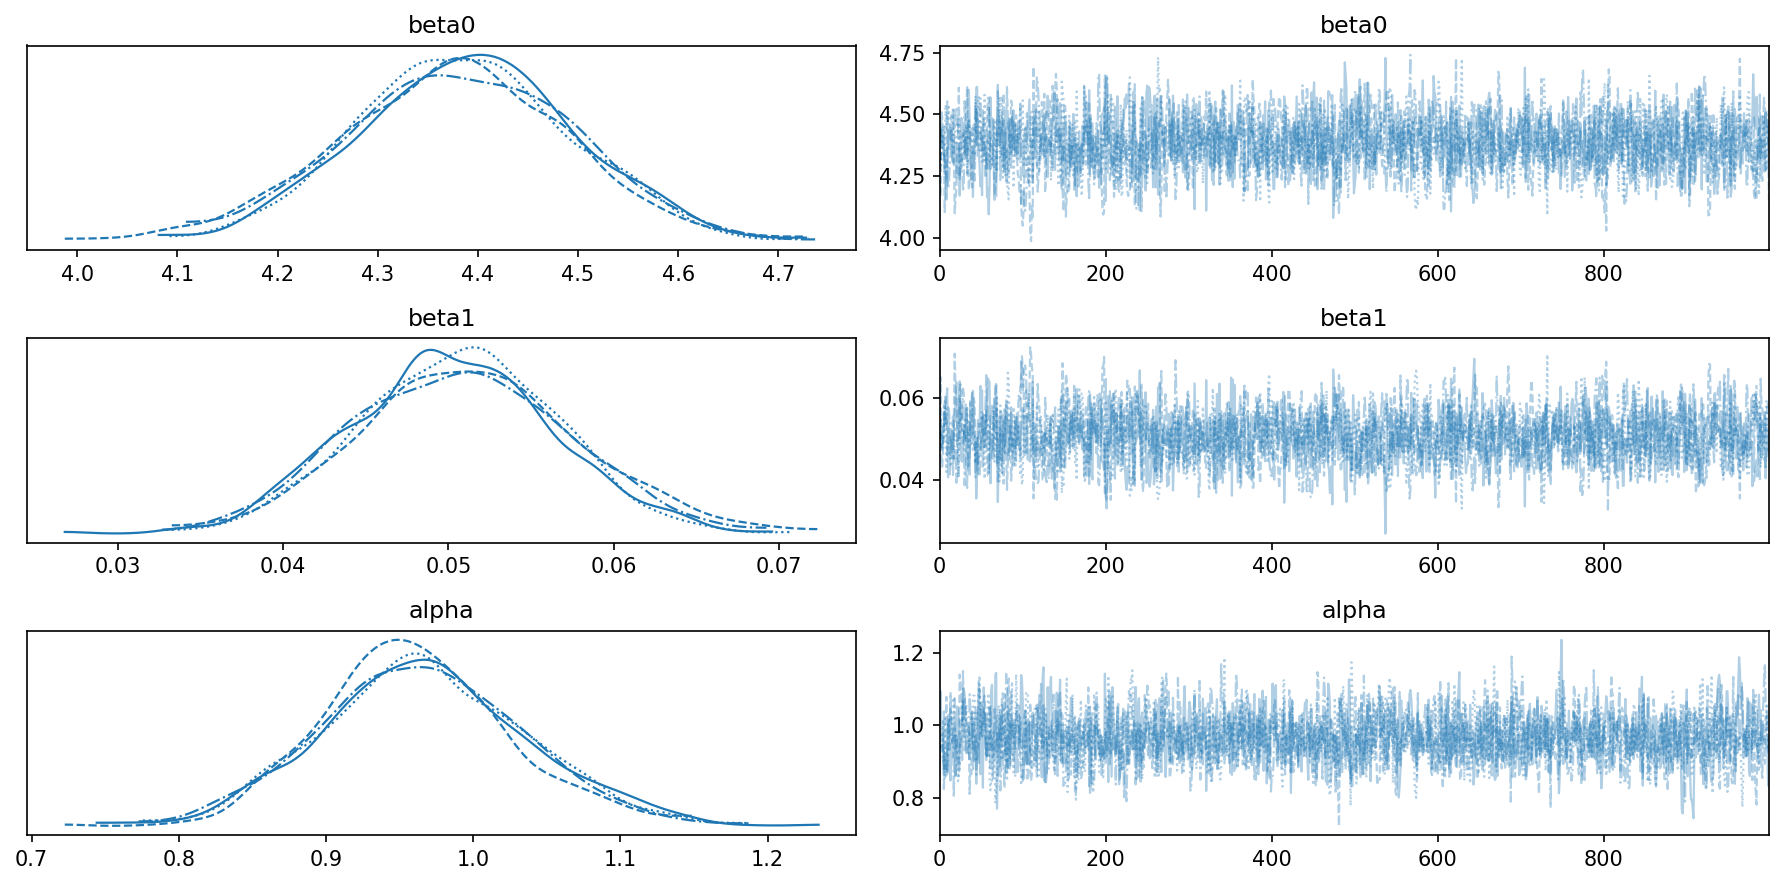

In [ ]:
az.plot_trace(idata_neg, var_names=["~mu"]);
plt.tight_layout()
plt.show()

In [ ]:
idata_neg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

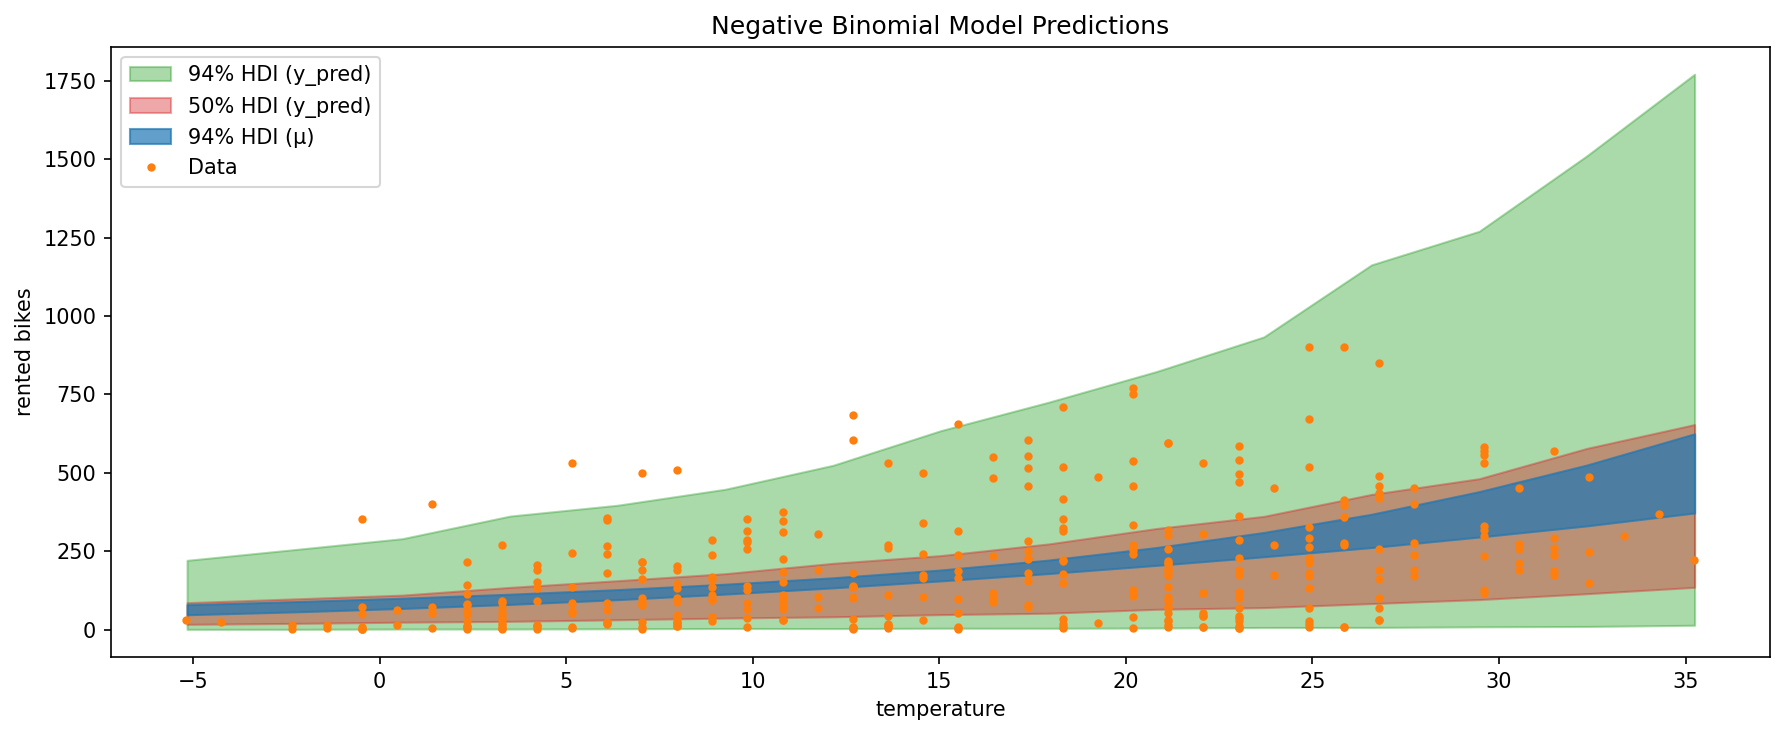

In [ ]:
# Setup
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

HDIs_pp = [0.94, 0.5]  # Multiple HDIs for posterior predictive
HDI_mu = 0.94          # Single HDI for posterior μ

# --- Posterior Predictive HDIs ---
pp_percentiles = []
for hdi in HDIs_pp:
    p_low = (1 - hdi) / 2
    p_high = 1 - p_low
    pp_percentiles.extend([p_low, p_high])

y_pred_q = idata_neg.posterior_predictive["y_pred"].quantile(pp_percentiles, dim=["chain", "draw"])

# Interpolated HDI bounds for y_pred
y_hat_bounds = {}
for i, hdi in enumerate(HDIs_pp):
    lb = y_pred_q[2 * i]
    ub = y_pred_q[2 * i + 1]
    y_hat_bounds[hdi] = (
        interpolate.PchipInterpolator(temperatures[idx], lb[idx])(x),
        interpolate.PchipInterpolator(temperatures[idx], ub[idx])(x)
    )

# --- Posterior μ HDI ---
p_low_mu = (1 - HDI_mu) / 2
p_high_mu = 1 - p_low_mu
# For the negative binomial model, mu is on log scale, so we need to exponentiate
mu_q = idata_neg.posterior["mu"].quantile([p_low_mu, p_high_mu], dim=["chain", "draw"])

mu_bounds = (
    interpolate.PchipInterpolator(temperatures[idx], mu_q[0][idx])(x),
    interpolate.PchipInterpolator(temperatures[idx], mu_q[1][idx])(x)
)

# --- Plot ---
_, ax = plt.subplots(figsize=(12, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Fill posterior predictive HDIs
for i, hdi in enumerate(HDIs_pp):
    lb, ub = y_hat_bounds[hdi]
    ax.fill_between(x, lb, ub, color=colors[i % len(colors)+2], alpha=0.4, label=f"{int(hdi*100)}% HDI (y_pred)", zorder=i)

# Fill μ HDI
mu_color = 'C0'
ax.fill_between(x, *mu_bounds, color=mu_color, alpha=0.7, label=f"{int(HDI_mu*100)}% HDI (μ)", zorder=len(HDIs_pp))

# Data points
ax.plot(bikes.temperature, bikes.rented, "C1.", label="Data", zorder=len(HDIs_pp)+1)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")
ax.legend()
plt.title("Negative Binomial Model Predictions")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'NegativeBinomial')

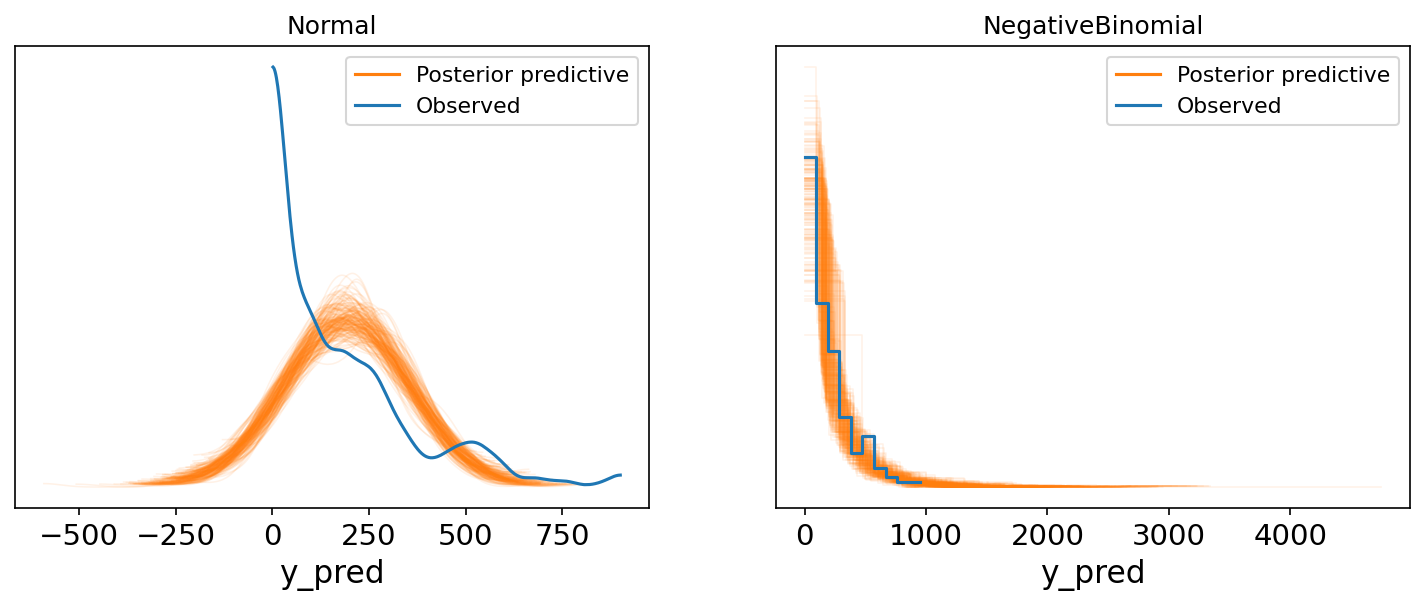

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(
    idata_lb,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[0],
    mean=False,
)
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[1],
    mean=False,
)
ax[0].set_title("Normal")
ax[1].set_title("NegativeBinomial")

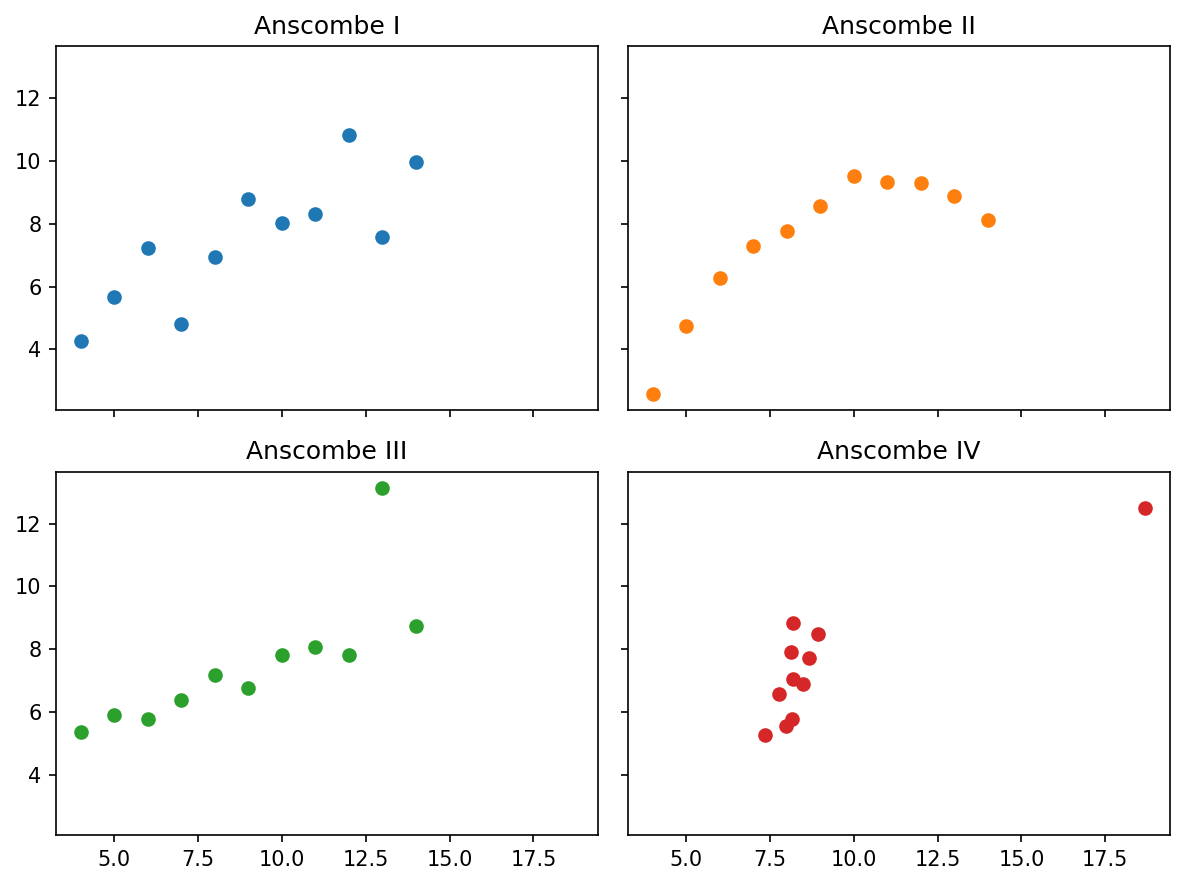

In [ ]:
# Anscombe's quartet data
# Normal data
x1 = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])

# Model mimatch
x2 = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74])
y2 = y2 + np.random.normal(0, 0.25, len(y2))

# Outlier
x3 = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
y3 = y3 + np.random.normal(0, 0.25, len(y3))

# Leverage
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89])
x4 = x4 + np.random.normal(0, 0.5, len(x4))

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

axs[0, 0].scatter(x1, y1, color="C0")
axs[0, 0].set_title("Anscombe I")
axs[0, 1].scatter(x2, y2, color="C1")
axs[0, 1].set_title("Anscombe II")
axs[1, 0].scatter(x3, y3, color="C2")
axs[1, 0].set_title("Anscombe III")
axs[1, 1].scatter(x4, y4, color="C3")
axs[1, 1].set_title("Anscombe IV")

plt.tight_layout()
plt.show()

In [ ]:
# Build and fit Gaussian regression models for each Anscombe dataset
def build_gaussian_model(x, y):
    coords = {"data": np.arange(len(x))}
    with pm.Model(coords=coords) as model:
        x_ = pm.Data("x", x, dims="data")
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", 10)
        mu = alpha + beta * x_
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y, dims="data")
    return model

# Prepare data
Xs = [x1, x2, x3, x4]
Ys = [y1, y2, y3, y4]

# Create models
models = []
for x_, y_ in zip(Xs, Ys):
    models.append(build_gaussian_model(x_, y_))

# Sample outside the with context
idatas_ans = []
for m_ in models:
    idatas_ans.append(pm.sample(model=m_, random_seed=123, cores=1))

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


C:\Users\User\AppData\Local\Temp\ipykernel_6412\2431745805.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(lines_, 0.94)
C:\Users\User\AppData\Local\Temp\ipykernel_6412\2431745805.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(lines_, 0.94)
C:\Users\User\AppData\Local\Temp\ipykernel_6412\2431745805.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(lines_, 0.94)
C:\Users\User\AppData\Local\Temp\ipykernel_6412\2431745805.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hd

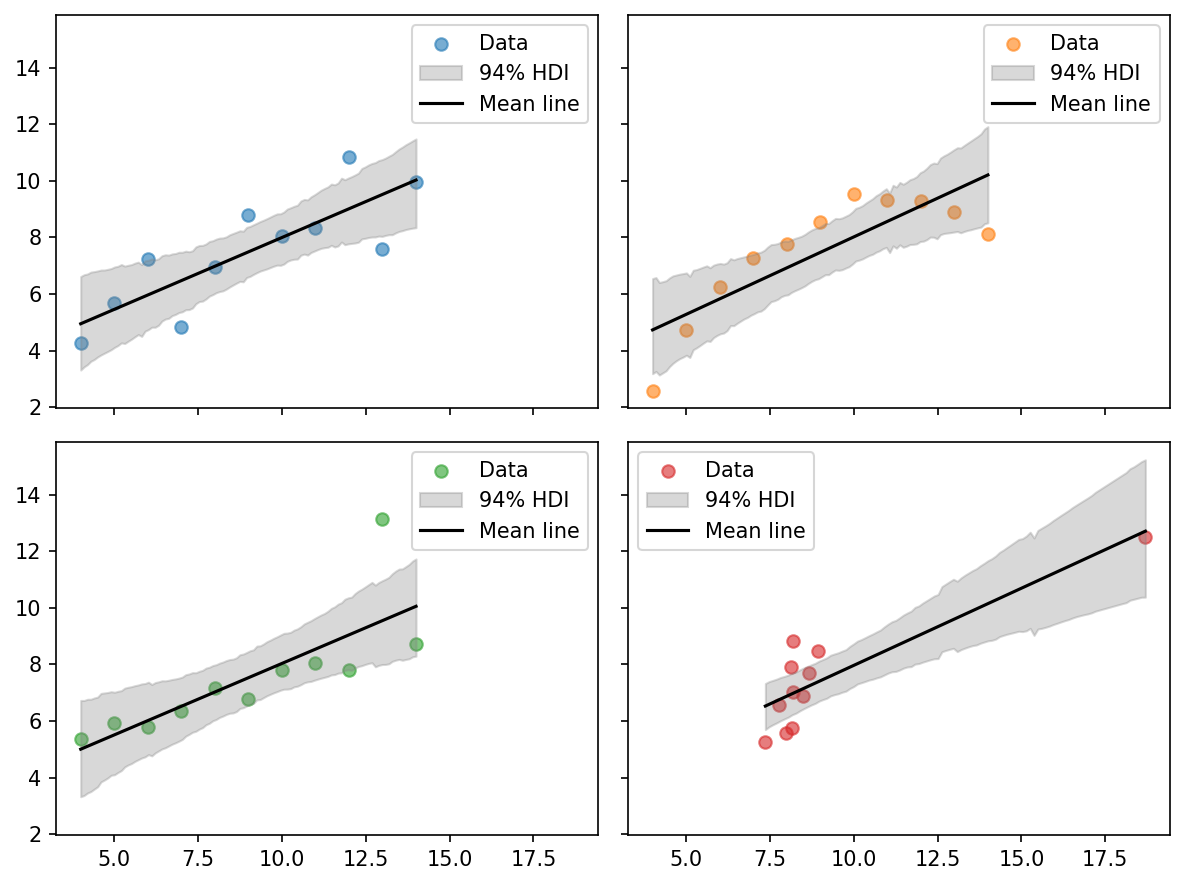

In [ ]:
# Plot each dataset with mean regression line and HDI
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, (x_, y_, idata_ans) in enumerate(zip(Xs, Ys, idatas_ans)):
    row, col = divmod(i, 2)
    x_plot_ = np.linspace(x_.min(), x_.max(), 100)
    posterior_ = az.extract(idata_ans)
    lines_ = (
        posterior_["alpha"].values[:, None]
        + posterior_["beta"].values[:, None] * x_plot_[None, :]
    )
    mean_line = lines_.mean(axis=0)
    hdi_ = az.hdi(lines_, 0.94)

    axs[row, col].scatter(x_, y_, c=f"C{i}", alpha=0.6, label="Data")
    axs[row, col].fill_between(
        x_plot_, hdi_[:, 0], hdi_[:, 1], color="gray", alpha=0.3, label="94% HDI"
    )
    axs[row, col].plot(x_plot_, mean_line, c="black", label="Mean line")
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [ ]:
for i, (idata_, model_) in enumerate(zip(idatas_ans, models)):
    # Sample from the posterior predictive, providing each InferenceData object and associated model
    pm.sample_posterior_predictive(
        idata_,
        model=model_,
        extend_inferencedata=True,
        random_seed=123,  # or any other seed
    )
    idata_.extend(pm.sample_prior_predictive(
        model=model_,
        random_seed=123,  # or any other seed
    ), join="right")


Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]


In [ ]:
    num_datasets_to_plot = 10  # Number of datasets to plotbeta
    # Extract exactly 10 draws from the prior and posterior
    prior_draws = az.extract(idata_, group="prior", num_samples=num_datasets_to_plot)
    prior_predictive_draws = az.extract(idata_, group="prior_predictive", num_samples=num_datasets_to_plot)
    posterior_draws = az.extract(idata_.posterior, num_samples=num_datasets_to_plot)
    posterior_predictive_draws = az.extract(idata_, group="posterior_predictive", num_samples=num_datasets_to_plot)
    
    # Generate an x-array for plotting lines
    x_plot = xr.DataArray(np.linspace(x_.min(), x_.max(), 50), dims="plot_id")

    # Lines from the prior (alpha + beta * x_plot)
    prior_lines = prior_draws["alpha"] + prior_draws["beta"] * x_plot

    # Lines from the posterior (alpha + beta * x_plot)
    posterior_lines = posterior_draws["alpha"] + posterior_draws["beta"] * x_plot

    y_prior = prior_predictive_draws["y_obs"]  # dims: (sample, data)
    y_posterior = posterior_predictive_draws["y_obs"]  # dims: (sample, data)


Text(0.5, 1.0, 'Anscombe III (Outlier)')

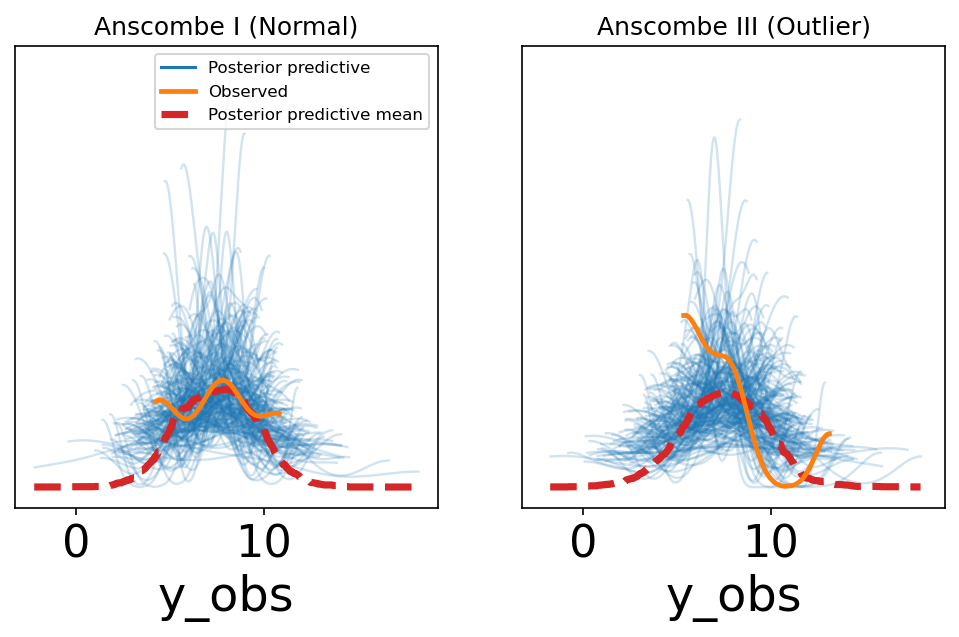

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
az.plot_ppc(idatas_ans[0], num_pp_samples=200, figsize=(12, 6), colors=["C0", "C1", "C3"], ax=ax[0], legend=True)
ax[0].legend(fontsize=8)
ax[0].set_title("Anscombe I (Normal)")
az.plot_ppc(idatas_ans[2], num_pp_samples=200, figsize=(12, 6), colors=["C0", "C1", "C3"], ax=ax[1], legend=False)
ax[1].set_title("Anscombe III (Outlier)")

In [ ]:
# Build and fit Student t models for each Anscombe dataset
def build_studentt_model(x, y):
    coords = {"data": np.arange(len(x))}
    with pm.Model(coords=coords) as model:
        x_ = pm.Data("x", x, dims="data")
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", 10)
        nu = pm.Exponential("nu", 1/29)
        mu = alpha + beta * x_
        pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=nu, observed=y, dims="data")
    return model


# Prepare data
Xs = [x1, x2, x3, x4]
Ys = [y1, y2, y3, y4]

# Create models
models_t = []
for x_, y_ in zip(Xs, Ys):
    models_t.append(build_studentt_model(x_, y_))

# Sample outside the with context
idatas_ans_t = []
for m_ in models_t:
    idatas_ans_t.append(pm.sample(model=m_, random_seed=123, cores=1))

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


C:\Users\User\AppData\Local\Temp\ipykernel_6412\1711824561.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(lines_, 0.94)
C:\Users\User\AppData\Local\Temp\ipykernel_6412\1711824561.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(lines_, 0.94)
C:\Users\User\AppData\Local\Temp\ipykernel_6412\1711824561.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(lines_, 0.94)
C:\Users\User\AppData\Local\Temp\ipykernel_6412\1711824561.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hd

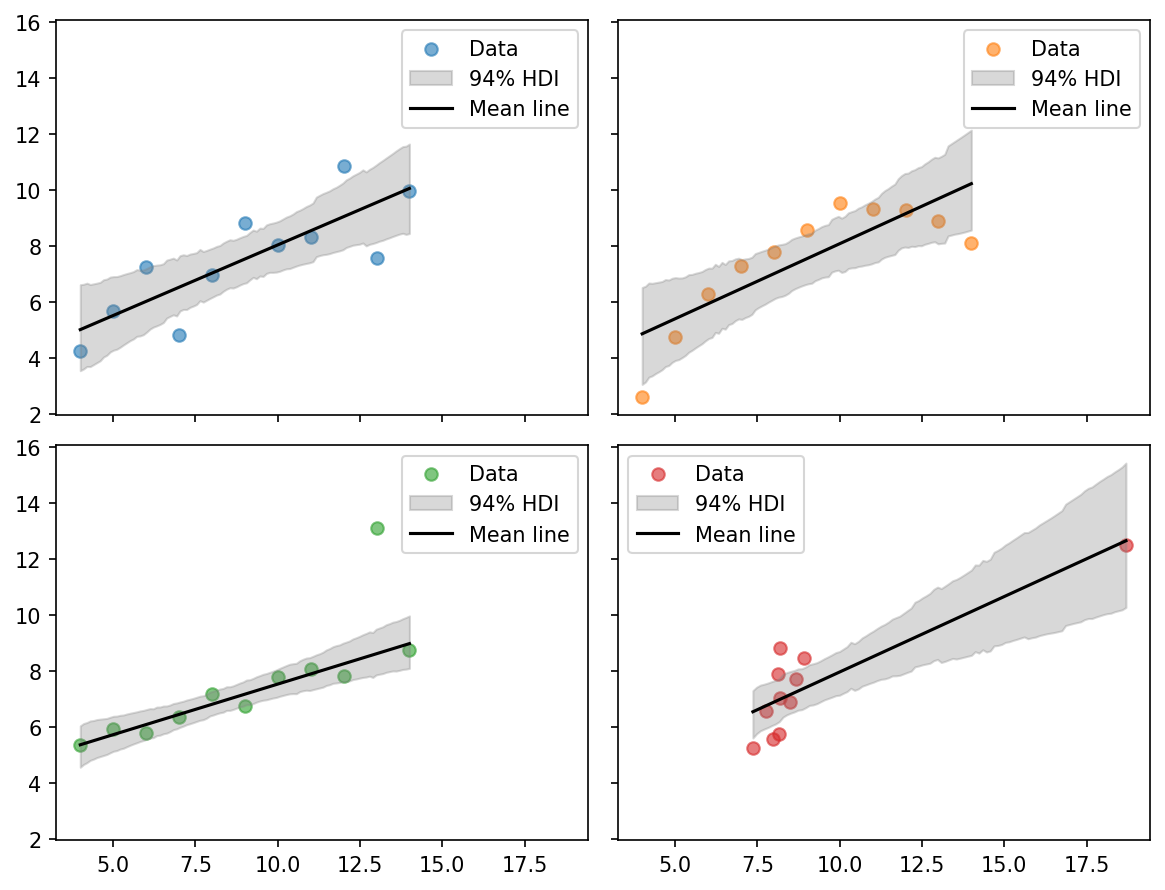

In [ ]:
# Plot each dataset with mean regression line and HDI
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, (x_, y_, idata_ans_t) in enumerate(zip(Xs, Ys, idatas_ans_t)):
    row, col = divmod(i, 2)
    x_plot_ = np.linspace(x_.min(), x_.max(), 100)
    posterior_ = az.extract(idata_ans_t)
    lines_ = (
        posterior_["alpha"].values[:, None]
        + posterior_["beta"].values[:, None] * x_plot_[None, :]
    )
    mean_line = lines_.mean(axis=0)
    hdi_ = az.hdi(lines_, 0.94)

    axs[row, col].scatter(x_, y_, c=f"C{i}", alpha=0.6, label="Data")
    axs[row, col].fill_between(
        x_plot_, hdi_[:, 0], hdi_[:, 1], color="gray", alpha=0.3, label="94% HDI"
    )
    axs[row, col].plot(x_plot_, mean_line, c="black", label="Mean line")
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [ ]:
for i, (idata_, model_) in enumerate(zip(idatas_ans_t, models)):
    # Sample from the posterior predictive, providing each InferenceData object and associated model
    pm.sample_posterior_predictive(
        idata_,
        model=model_,
        extend_inferencedata=True,
        random_seed=123,  # or any other seed
    )
    idata_.extend(pm.sample_prior_predictive(
        model=model_,
        random_seed=123,  # or any other seed
    ), join="right")

Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]
Sampling: [y_obs]


Output()

Sampling: [alpha, beta, sigma, y_obs]


(np.float64(-0.03585854855826189), np.float64(0.7530295197234997))


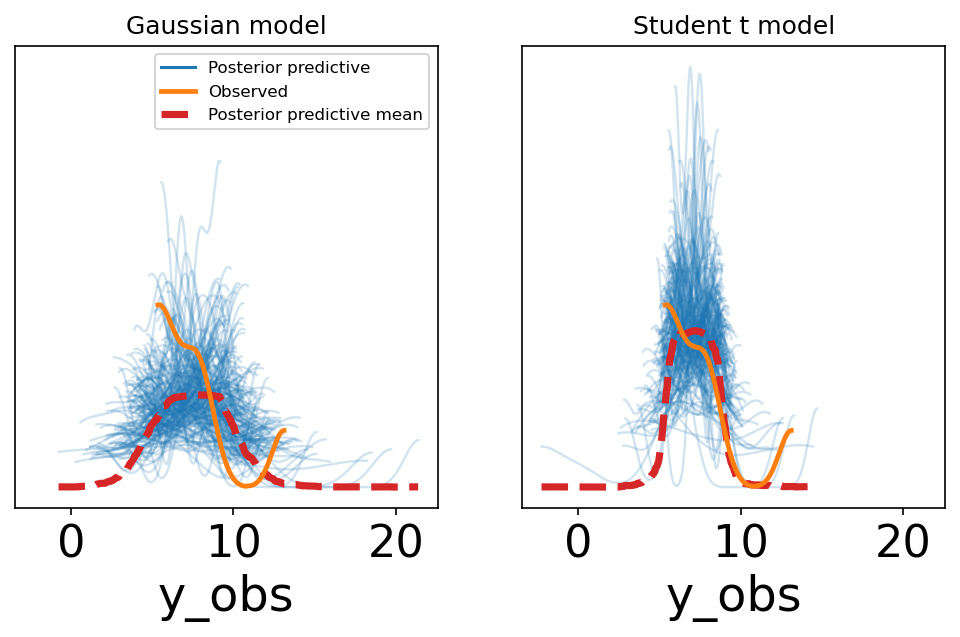

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
az.plot_ppc(idatas_ans[2], num_pp_samples=200, figsize=(12, 6), colors=["C0", "C1", "C3"], ax=ax[0], legend=False)
ax[0].legend(fontsize=8)
ax[0].set_title("Gaussian model")
az.plot_ppc(idatas_ans_t[2], num_pp_samples=200, figsize=(12, 6), colors=["C0", "C1", "C3"], ax=ax[1], legend=False)
ax[1].set_title("Student t model")

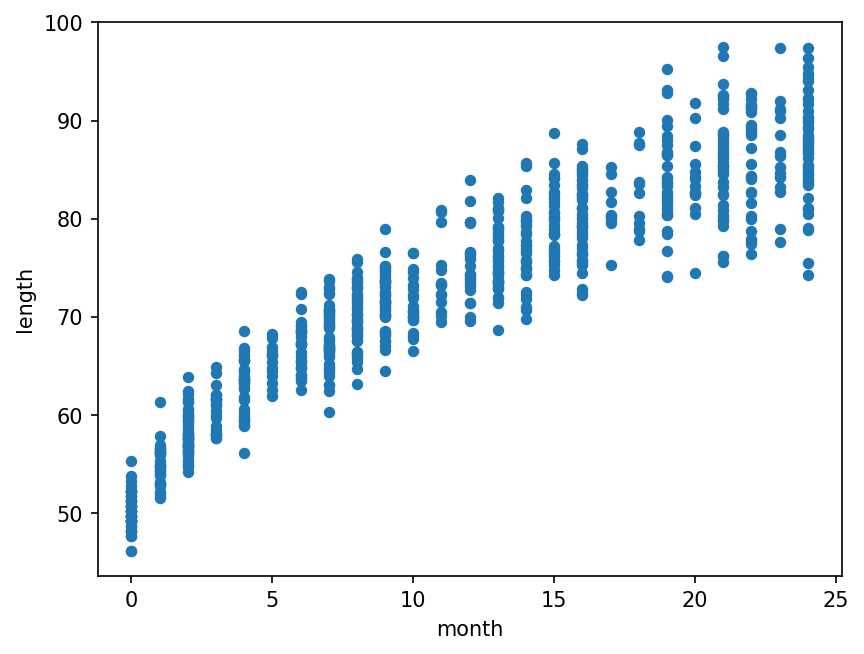

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/babies.csv")
data.plot.scatter("month", "length");

In [ ]:
coords = {"month": range(len(data.month))}
with pm.Model(coords=coords) as model_vv:
    x_shared = pm.Data("x_shared", data.month.values.astype(float), dims=["month"])
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    μ = pm.Deterministic("μ", α + β * x_shared**0.5, dims=["month"])
    σ = pm.Deterministic("σ", γ + δ * x_shared, dims=["month"])

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.length, dims=["month"])



In [ ]:

idata_vv = pm.sample(random_seed=123, model=model_vv)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


Text(0, 0.5, 'length')

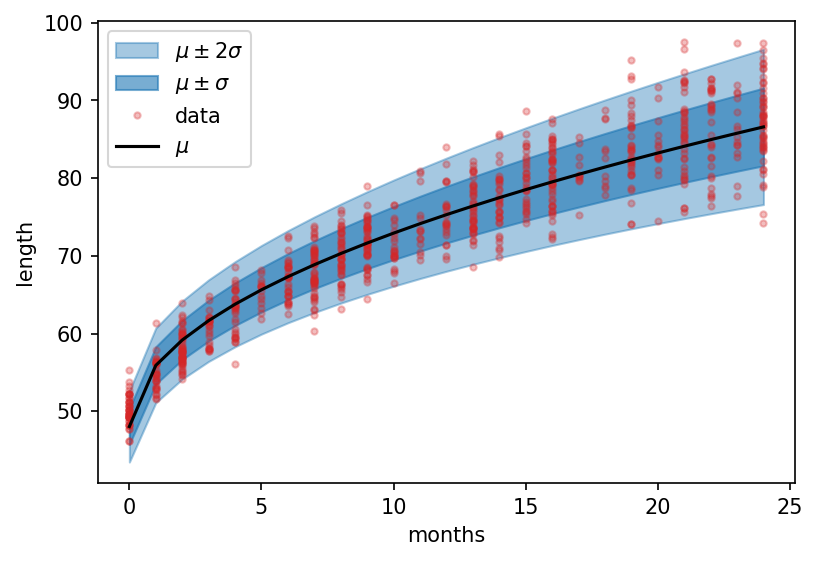

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))

posterior = az.extract(idata_vv)

μ_m = posterior["μ"].mean("sample").values
σ_m = posterior["σ"].mean("sample").values

ax.fill_between(data.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C0", label=r"$\mu \pm 2 \sigma$")
ax.fill_between(data.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C0", label=r"$\mu \pm \sigma$")
ax.plot(data.month, data.length, "C3.", alpha=0.3, label="data")
ax.plot(data.month, μ_m, c="k", label=r"$\mu$")

ax.legend()
ax.set_xlabel("months")
ax.set_ylabel("length")


In [ ]:
with model_vv:
    pm.set_data({"x_shared": [0.5]}, coords={"month": [0.5]})
    ppc = idata_vv.extend(pm.sample_posterior_predictive(idata_vv, var_names=['y_pred'], predictions=True, random_seed=123), join="right")
    

Sampling: [y_pred]


Output()

In [ ]:
idata_vv

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

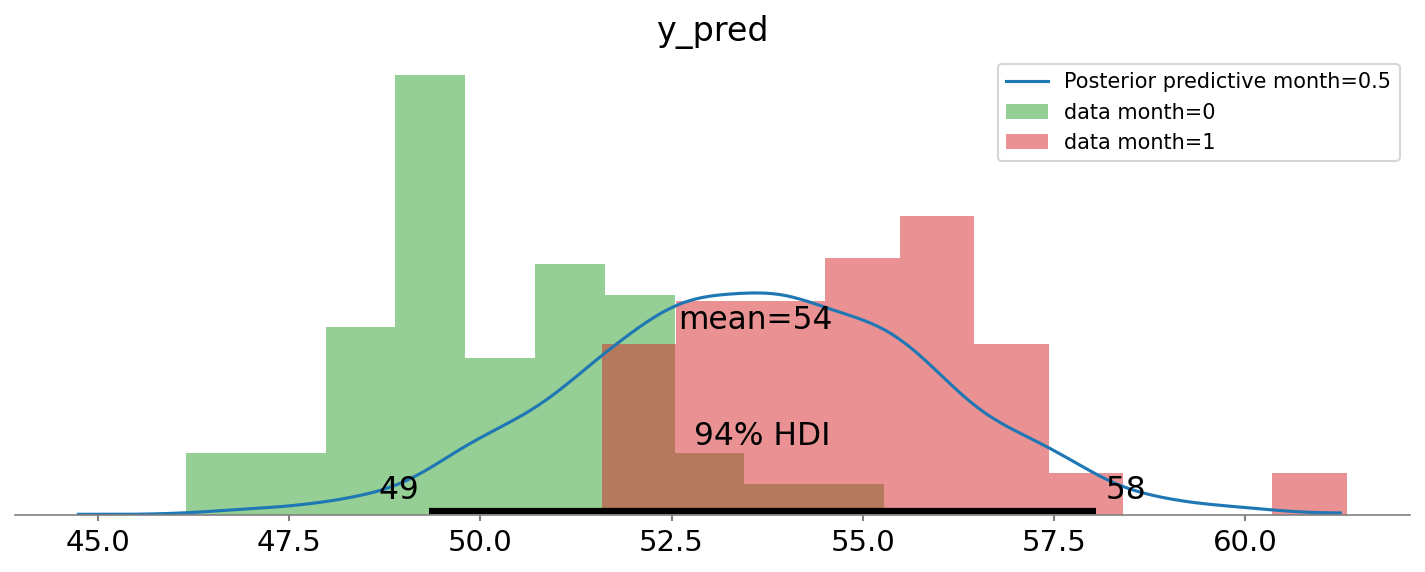

In [ ]:
y_ppc = idata_vv.predictions["y_pred"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(12, 4))
az.plot_posterior(y_ppc, combine_dims={"sample", "month"}, hdi_prob=0.94, ax=ax)
# Add a dummy plot for the posterior predictive to include it in the legend
ax.plot([], [], color="C0", label="Posterior predictive month=0.5")

month0 = data.loc[data.month == 0, "length"]
month1 = data.loc[data.month == 1, "length"]

ax.hist(month0, alpha=0.5, color="C2", density=True, label="data month=0")
ax.hist(month1, alpha=0.5, color="C3", density=True, label="data month=1")
ax.legend()